<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, SOUL, and VI to the Bayesian latent space network model from Hoff et al. (2002). 

# Latent space network model - Game of Thrones

First, we load the modules that we will need:

In [1]:
import os
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import procrustes

# Numpy for computations.
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)

# Pyplot for plots.
import matplotlib.pyplot as plt 

This dataset contains interactions between Games of Thrones characters during the first 4 seasons of the TV show. An edge exists between characters if they have interacted (i.e. spoken) with one another during that season of the show.

In [2]:
from load_got import load_got
from coinem.dataset import Dataset

# Load GoT character interaction networks
Y, names = load_got(seasons=[1,2,3,4], weight_min=10)
y = jnp.asarray(Y[3])
season = 'season_4'

#Remove the rows and columns which contain only zero entries, i.e. degree=0
names = names[np.where(np.sum(y,1)!=0)[0]]
ytemp = np.delete(y,np.where(np.sum(y,1)==0),0)
y = np.delete(ytemp,np.where(np.sum(ytemp,0)==0),1)
Y =y
data = Dataset(y=y)

The data we model consist of an $D \times D$ matrix Y, with each entry $y_{i,j}$ denoting the value of the relation from node $i$ to node $j$. We focus on binary-valued relations, although this could be extended to more general relations, e.g. count data or weighted networks. These extensions to more general relations are essentially alternative generalised linear models. Both directed and undirected relations can be analysed with the following model.

We take a conditional independence approach to modeling by assuming that the presence or absence of a tie between two individuals (i.e. nodes) is independent of all other ties in the system, given the unobserved positions in social space of the two individuals,

$P(Y|X,\theta) = \prod_{i \neq j} P(y_{i,j}|x_{i,j},\theta)$.

A convenient model for $P(y_{i,j}|x_{i,j},\theta)$ is the logistic regression model, where the probability of a tie between nodes $i$ and $j$ depends on the Euclidean distance between $x_i$ and $x_j$,

$\eta_{i,j} = \mbox{log-odds}(y_{i,j}=1|x_i, x_j, \theta) = \alpha - ||x_i-x_j||.$

In [3]:
from coinem.dataset import Dataset
from coinem.model import AbstractModel
from jaxtyping import Array, Float
from dataclasses import dataclass

@dataclass
class GOTModel(AbstractModel):

    def log_prob(self, latent: Float[Array, "P D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        
        z = latent

        #dist = jnp.matmul(z,z.T)/jnp.linalg.norm(z,axis=1)
        dist = -jnp.sqrt(jnp.sum((z[None, :] - z[:, None])**2, -1)+10e-6)
        
        eta = theta + dist
        log_prior =  -jnp.sum(jnp.dot(z.T,z))  
        log_lik = jnp.sum(jnp.multiply(data.y.squeeze(), eta) - jnp.log1p(jnp.exp(eta)))
        return log_lik + log_prior



#log-target density p_theta(y,x)
def log_target(th, z):
    dist = jnp.sqrt(jnp.sum((z[None, :] - z[:, None])**2, -1)+10e-6)
    eta = th - dist
    log_prior =  -jnp.sum(jnp.dot(z.T,z))  
    log_lik = jnp.sum(jnp.multiply(y,eta) - jnp.log1p(jnp.exp(eta)))
    return log_lik + log_prior


grad_theta = grad(log_target, 0)
grad_x = grad(log_target,1)

def procrustes_transform(X, mle):
    Xtrans = np.copy(X)
    N = np.shape(X)[0]
    for i in range(N):
        _, Xtrans[i,:,:], _ = procrustes(mle, X[i,:,:])    
    return Xtrans
 

We then implement the algorithms. They take the following inputs:

*   y : D x D adjacency matrix,
*   h : step size parameter 
*   K : number of steps,
*   N : number of particles,
*   th : 1-dimensional vector with parameter guess,
*   X : D x N matrix storing the initial particle cloud.

The following inference algorithms return the following outputs:

*   th : K-dimensional vector of parameter estimates,
*   X : [D, 2, N]) matrix storing the particle clouds, assuming a 2-dimensional latent space.

## Run the inference algorithms to learn $\theta$ and the latent positions of the network nodes $X$

We start by running a simple gradient descent algorithm to find the maximum likelihood estimate for $\theta$ and $X$.

In [4]:
#Find the MLE
D = Y.shape[0]

# Initialize parameter estimates and particle cloud, all at zero:
key, x_key = random.split(key, 2)
th = jnp.array([[1.0]])  # Parameter estimate.
x = 0.1*random.normal(x_key,(D, 2))

lr = 0.01
for step in range(10000):
    x_grad = grad_x(th,x)
    x += lr*x_grad
    th_grad = grad_theta(th,x) 
    th += lr*th_grad
    if step % 1000 == 0:
        print('Log_target', log_target(th,x))
        print('theta',th)

#Because reflections, rotations and translations of X will lead to the same likelihood value, so use a procrustean transformation X to a reference set X0.
Xmle, _ ,_ = procrustes(random.normal(x_key,(D, 2)), x)  

Log_target -10308.652
theta [[-31.618065]]
Log_target -798.88416
theta [[0.19081044]]
Log_target -759.45197
theta [[0.45906997]]
Log_target -741.5118
theta [[0.5576849]]
Log_target -730.4495
theta [[0.59934175]]
Log_target -722.9768
theta [[0.61719036]]
Log_target -717.531
theta [[0.6242491]]
Log_target -713.5285
theta [[0.62787104]]
Log_target -710.54816
theta [[0.6277789]]
Log_target -708.2368
theta [[0.62658596]]


In [5]:
# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 500  # Number of steps.
N = 10  # Number of particles.
D = y.shape[0]

X0 = 0.01*random.normal(key,(N, D, 2)) + Xmle[None, :]
    
# Run algorithms:

model = GOTModel()

from coinem.network_zoo import pgd, coin_svgd, soul

th0 = jnp.array([[1.0]])  # Parameter estimate.

# Run algorithms:
z_pgd, th_pgd  = pgd(model, data, X0, th0, K, latent_step_size = 1e-3, theta_step_size = 1e-3)
z_soul, th_soul  = soul(model, data, X0, th0, K, latent_step_size = 1e-3, theta_step_size = 1e-3)
z_coin, th_coin = coin_svgd(model, data, X0, th0, K)

#Procrustes transformation - post-processing step
Z_pgd = procrustes_transform(z_pgd[-1], Xmle)
Z_soul = procrustes_transform(z_soul[-1], Xmle)
Z_coin = procrustes_transform(z_coin[-1], Xmle)


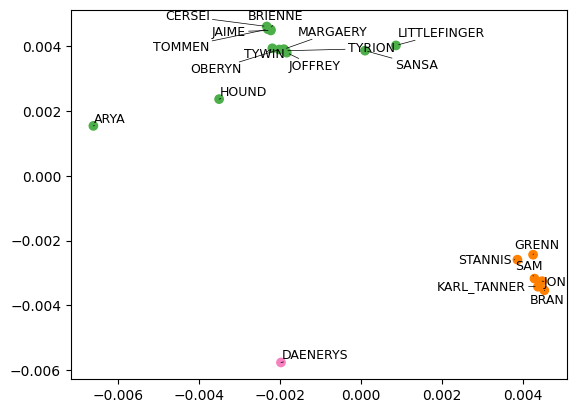

In [7]:
#Plot the latent positions for Coin
import pandas as pd
from adjustText import adjust_text
from sklearn.cluster import DBSCAN, KMeans

avg_Z_coin = jnp.mean(Z_coin,axis=0)

clustering = DBSCAN(eps=0.003, min_samples=2).fit(avg_Z_coin)
clusters = clustering.labels_+abs(min(clustering.labels_))

indx = jnp.sum(y,1)>4
plotting_index = np.where(indx*np.arange(D)!=0)[0]

colormap = np.array(['#377eb8', '#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00'])
plt.scatter(avg_Z_coin[plotting_index,0],avg_Z_coin[plotting_index,1],c=colormap[clusters[plotting_index]])

force_points =1
texts = []
for x_pos, y_pos, s in zip(avg_Z_coin[plotting_index,0], avg_Z_coin[plotting_index,1], names[plotting_index]):
    texts.append(plt.text(x_pos, y_pos, s, size=9))

adjust_text(texts, force_points=0.001, arrowprops=dict(arrowstyle="-", color="k", lw=0.5))
plt.savefig('got_network_latent_variables_'+season+'_coin.pdf')

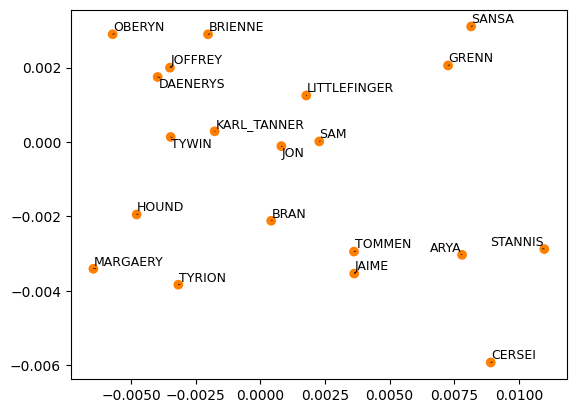

In [8]:
#Plot the latent positions for PGD

avg_Z_pgd = jnp.mean(Z_pgd,axis=0)

clustering = DBSCAN(eps=0.003, min_samples=2).fit(avg_Z_pgd)
clusters = clustering.labels_+abs(min(clustering.labels_))

indx = jnp.sum(y,1)>4
plotting_index = np.where(indx*np.arange(D)!=0)[0]


colormap = np.array(['#377eb8', '#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00'])
plt.scatter(avg_Z_pgd[plotting_index,0],avg_Z_pgd[plotting_index,1],c=colormap[clusters[plotting_index]])

force_points =1
texts = []
for x_pos, y_pos, s in zip(avg_Z_pgd[plotting_index,0], avg_Z_pgd[plotting_index,1], names[plotting_index]):
    texts.append(plt.text(x_pos, y_pos, s, size=9))

adjust_text(texts, force_points=0.001, arrowprops=dict(arrowstyle="-", color="k", lw=0.5))
plt.savefig('got_network_latent_variables_'+season+'_pgd.pdf')

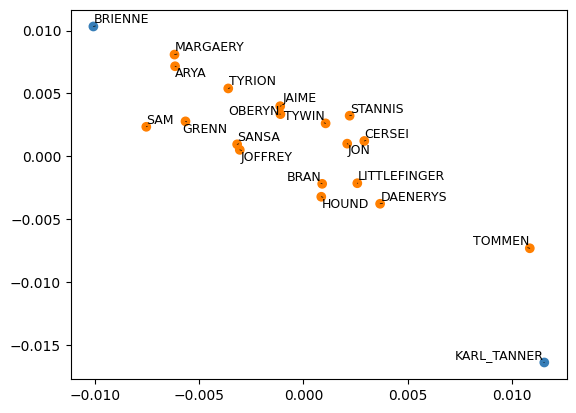

In [9]:
#Plot the latent positions for Soul

avg_Z_soul = jnp.mean(Z_soul,axis=0)

clustering = DBSCAN(eps=0.003, min_samples=2).fit(avg_Z_soul)
clusters = clustering.labels_+abs(min(clustering.labels_))

indx = jnp.sum(y,1)>4
plotting_index = np.where(indx*np.arange(D)!=0)[0]

colormap = np.array(['#377eb8', '#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00'])
plt.scatter(avg_Z_soul[plotting_index,0],avg_Z_soul[plotting_index,1],c=colormap[clusters[plotting_index]])

force_points =1
texts = []
for x_pos, y_pos, s in zip(avg_Z_soul[plotting_index,0], avg_Z_soul[plotting_index,1], names[plotting_index]):
    texts.append(plt.text(x_pos, y_pos, s, size=9))

adjust_text(texts, force_points=0.001, arrowprops=dict(arrowstyle="-", color="k", lw=0.5))
plt.savefig('got_network_latent_variables_'+season+'_soul.pdf')

And plot the parameter estimate $\theta$ as a function of k:

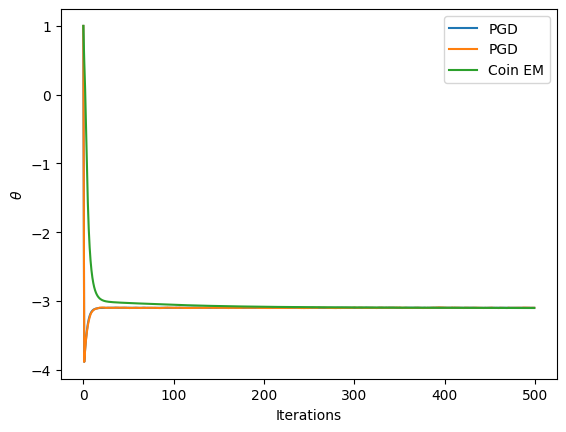

In [10]:
#plt.plot(th_vi, label='VI')
plt.plot(th_pgd[:,:,1], label='PGD')
plt.plot(th_soul[:,:,1], label='PGD')
plt.plot(th_coin[:,:,1], label='Coin EM')
plt.xlabel('Iterations')
plt.ylabel(r'$\theta$')
plt.legend(loc='upper right')
plt.savefig('got_network_theta_'+season+'.pdf')